In [1]:
import mne
import os.path as op
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import copy
import statsmodels.stats.multitest as mul

In [3]:
TF = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_evoked_planar2.h5', condition=None)[0]



Reading /home/vtretyakova/Рабочий стол/time_frequency_plots/donor_evoked_planar2.h5 ...


/tmp/ipykernel_10930/2081611930.py:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_evoked_planar2.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  TF = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_evoked_planar2.h5', condition=None)[0]


In [4]:
TF

<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 102, ~26.0 MB>

In [5]:
type(TF)

mne.time_frequency.tfr.AverageTFR

In [7]:
TF.data.shape

(102, 20, 1350)

In [8]:
TF.data[68].shape

(20, 1350)

# Add channel axis

In [11]:
best_chan = np.zeros((3, 20, 1350))

In [13]:
best_chan_list = [68, 75, 76]

In [17]:
for ind, c in enumerate(best_chan_list):
    best_chan[ind] = TF.data[c]

best_chan.shape

(3, 20, 1350)

In [18]:
type(best_chan)

numpy.ndarray

In [20]:
best_chan_mean = best_chan.mean(axis = 0)

In [21]:
best_chan_mean.shape

(20, 1350)

In [22]:
TF.data[0]

array([[-2.11563247, -1.80738852, -1.53245604, ..., -2.10664666,
        -2.3374024 , -2.62334023],
       [-0.28469853, -0.20484021, -0.14080775, ..., -2.49189922,
        -2.56579262, -2.65795052],
       [ 2.24960108,  2.25738925,  2.27424952, ..., -0.76109564,
        -0.86121014, -0.92884671],
       ...,
       [-8.88942754, -9.20985168, -8.50824679, ..., -2.73824285,
        -2.78406281, -3.1109038 ],
       [-4.18432038, -3.97171729, -3.48077587, ..., -2.43217288,
        -2.59134642, -3.01632092],
       [-4.31823981, -3.98703148, -3.63338742, ..., -3.41407134,
        -2.90671077, -2.63676674]])

In [23]:
best_chan_mean

array([[-3.58558787, -3.60686406, -3.54051054, ..., -0.17333922,
        -0.33830555, -0.48103604],
       [-3.07594983, -3.03436854, -2.92201325, ..., -0.25437025,
        -0.35340379, -0.44661251],
       [-4.02777482, -3.95574889, -3.83332362, ..., -2.09803784,
        -2.05824639, -2.08292139],
       ...,
       [-4.97382288, -5.15753081, -5.04142837, ..., -6.4597936 ,
        -6.21582936, -6.28642665],
       [-6.02513993, -5.73836498, -5.31103908, ..., -7.40042498,
        -7.25787777, -7.03146196],
       [-5.65091027, -5.50584518, -5.17551813, ..., -5.7619862 ,
        -6.02475671, -6.36719121]])

In [24]:
TF.data[0] = best_chan_mean



In [25]:
TF.data[0]

array([[-3.58558787, -3.60686406, -3.54051054, ..., -0.17333922,
        -0.33830555, -0.48103604],
       [-3.07594983, -3.03436854, -2.92201325, ..., -0.25437025,
        -0.35340379, -0.44661251],
       [-4.02777482, -3.95574889, -3.83332362, ..., -2.09803784,
        -2.05824639, -2.08292139],
       ...,
       [-4.97382288, -5.15753081, -5.04142837, ..., -6.4597936 ,
        -6.21582936, -6.28642665],
       [-6.02513993, -5.73836498, -5.31103908, ..., -7.40042498,
        -7.25787777, -7.03146196],
       [-5.65091027, -5.50584518, -5.17551813, ..., -5.7619862 ,
        -6.02475671, -6.36719121]])

No baseline correction applied


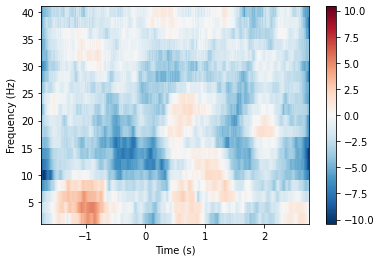

In [26]:
b = TF.plot([0], baseline=None);







# With stat

In [27]:
freq_range = '2_40_step_2_time_bandwidth_by_default_4_early_log'

subjects = []
for i in range(0,63):
    if i < 10:
        subjects += ['P00' + str(i)]
    else:
        subjects += ['P0' + str(i)]

# следующие испытуемы удаляются из выборки по причине возраста (>40 лет), либо нерискующие
subjects.remove('P000')
subjects.remove('P020')
subjects.remove('P036')
subjects.remove('P049')
subjects.remove('P056')

'''
# у следующих испытуемых риски удалились после коррекции меток (удаления технических артефактов и восставновления недостающих (Лера)). У этих испытуемых "Риски" были повторными, а мы брали, только одиночные
subjects.remove('P005')
subjects.remove('P037')
subjects.remove('P061')

'''
  
###################### при построении topomaps берем только тех испытуемых, у которых есть все категории условий ####################
### extract subjects with all conditions:fb+trial_type ####
cond_list = ['_norisk_fb_cur_positive',
             '_prerisk_fb_cur_positive',
             '_risk_fb_cur_positive',
             '_postrisk_fb_cur_positive',
             '_norisk_fb_cur_negative',
             '_prerisk_fb_cur_negative',
             '_risk_fb_cur_negative',
             '_postrisk_fb_cur_negative'
             ]

out_path='/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/beta_16_30_epo/' #path to epochs
f = os.listdir(out_path) # Делает список всех файлов, которые храняться в папке


subj_list = subjects.copy()
for i,subject in enumerate(subjects):
    subject_files = [file for file in f if subject in file] #make list with all subject files 
    for j in cond_list: #check if subject has all conditions
        if not any(j in s for s in subject_files):
            if subject in subj_list:
                subj_list.remove(subject)

subjects = subj_list
print(len(subjects))

########################## Combined planars ####################################

# донор (donor creation see make_donor_for_tfr_plot.ipynb)
donor = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/{0}/donor_planar1_evoked.h5'.format(freq_range), condition=None)[0]

n = donor.data.shape[2] # количество временных точек (берем у донора, если донор из тех же данных.
fr = donor.data.shape[1] # number of frequencies  (берем у донора, если донор из тех же данных.

#os.makedirs('/home/vtretyakova/Рабочий стол/time_frequency_plots/{0}_comb_planar'.format(freq_range), exist_ok = True)
os.makedirs('/home/vtretyakova/Рабочий стол/time_frequency_plots/test', exist_ok = True)


data_path = '/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/{0}/{0}_comb_planars'.format(freq_range)

40
Reading /net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/donor_planar1_evoked.h5 ...


/tmp/ipykernel_10930/1369675684.py:55: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/donor_planar1_evoked.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  donor = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/{0}/donor_planar1_evoked.h5'.format(freq_range), condition=None)[0]


In [28]:
p1 = 'norisk'
p2 = 'risk'

best_chan_list = [68, 75, 76]
interval = 'decision_making'


In [29]:
subj_list

['P001',
 'P002',
 'P004',
 'P006',
 'P007',
 'P008',
 'P011',
 'P014',
 'P015',
 'P016',
 'P017',
 'P019',
 'P021',
 'P022',
 'P023',
 'P024',
 'P025',
 'P028',
 'P029',
 'P030',
 'P031',
 'P032',
 'P033',
 'P034',
 'P035',
 'P039',
 'P040',
 'P042',
 'P043',
 'P044',
 'P045',
 'P047',
 'P048',
 'P052',
 'P053',
 'P055',
 'P057',
 'P059',
 'P060',
 'P062']

In [51]:
subj = 'P001'
contr = np.zeros((4, 102, fr, n))
parameter1 = 'risk'
planar = 'comb_planar'

In [52]:
temp1 = mne.time_frequency.read_tfrs(op.join(data_path, '{0}_{1}_average_{2}_resp_{3}.h5'.format(subj, parameter1, freq_range, planar)))[0]
		

Reading /net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/2_40_step_2_time_bandwidth_by_default_4_early_log_comb_planars/P001_risk_average_2_40_step_2_time_bandwidth_by_default_4_early_log_resp_comb_planar.h5 ...


/tmp/ipykernel_10930/1313288948.py:1: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/2_40_step_2_time_bandwidth_by_default_4_early_log_comb_planars/P001_risk_average_2_40_step_2_time_bandwidth_by_default_4_early_log_resp_comb_planar.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  temp1 = mne.time_frequency.read_tfrs(op.join(data_path, '{0}_{1}_average_{2}_resp_{3}.h5'.format(subj, parameter1, freq_range, planar)))[0]


In [54]:
contr[0, :, :, :] = temp1.data

In [55]:
contr[0].shape

(102, 20, 1350)

In [68]:
contr[0][0]

array([[-4.71592292, -4.56084605, -4.48102649, ..., -6.98043319,
        -7.11590207, -7.30723467],
       [-3.96725078, -3.70791185, -3.5959965 , ..., -6.6194406 ,
        -6.74374182, -6.88912268],
       [-0.85323295, -0.62842458, -0.44156545, ..., -5.50744013,
        -5.67014009, -5.79303777],
       ...,
       [-7.03487709, -7.01309019, -6.6781098 , ..., -6.33791735,
        -6.41728153, -6.56282509],
       [-7.02584426, -6.36104725, -5.96807625, ..., -6.06782194,
        -6.20230107, -6.41701971],
       [-7.06149724, -6.40598706, -6.28346704, ..., -7.65113429,
        -7.53571611, -7.59825539]])

In [63]:
best_chan1 = np.zeros((3, 20, 1350))
for j, c in enumerate(best_chan_list):
    best_chan1[j] = temp1.data[c]

In [64]:
best_chan_mean1 = best_chan1.mean(axis = 0)

In [66]:
best_chan_mean1.shape

(20, 1350)

In [67]:
best_chan_mean1

array([[-3.82342603, -3.64897401, -3.44089617, ..., -4.98967009,
        -5.064163  , -5.14683477],
       [-5.70361632, -5.53605269, -5.28636263, ..., -6.53977734,
        -6.6621944 , -6.79778949],
       [-8.54363234, -8.39098429, -8.14678975, ..., -8.12725441,
        -8.33008169, -8.5219447 ],
       ...,
       [-7.60580243, -7.59685408, -7.45404937, ..., -5.41551758,
        -5.39148963, -5.48641372],
       [-8.53440993, -8.41736222, -8.0649098 , ..., -5.3865191 ,
        -5.40268535, -5.42165033],
       [-8.0511604 , -7.78266833, -7.18941375, ..., -5.10445852,
        -5.30925007, -5.51285975]])

In [69]:
contr[0, 0, :, :] = best_chan_mean1

In [70]:
contr[0][0]

array([[-3.82342603, -3.64897401, -3.44089617, ..., -4.98967009,
        -5.064163  , -5.14683477],
       [-5.70361632, -5.53605269, -5.28636263, ..., -6.53977734,
        -6.6621944 , -6.79778949],
       [-8.54363234, -8.39098429, -8.14678975, ..., -8.12725441,
        -8.33008169, -8.5219447 ],
       ...,
       [-7.60580243, -7.59685408, -7.45404937, ..., -5.41551758,
        -5.39148963, -5.48641372],
       [-8.53440993, -8.41736222, -8.0649098 , ..., -5.3865191 ,
        -5.40268535, -5.42165033],
       [-8.0511604 , -7.78266833, -7.18941375, ..., -5.10445852,
        -5.30925007, -5.51285975]])